<a href="https://colab.research.google.com/github/ldaniel-hm/eml_tabular/blob/main/evaluacion_bellman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


In [104]:
# =============================================================================
# Clase Maze: representa el laberinto y se encarga de generarlo y gestionar sus celdas.
# =============================================================================
class Maze:
    def __init__(self, n, m, p_obstacle=0.2, seed=None):
        """
        Parámetros:
          - n, m: dimensiones del laberinto.
          - p_obstacle: probabilidad de que una celda sea un obstáculo.
          - seed: semilla para la generación aleatoria.
        """
        self.n = n
        self.m = m
        if seed is not None:
            np.random.seed(seed)
        # Se genera la cuadrícula: 1 = celda transitable, 0 = obstáculo.
        # self.grid = np.random.choice([0, 1], size=(n, m), p=[p_obstacle, 1 - p_obstacle])
        self.grid = np.ones((n, m), dtype=int)
        self.grid[1:-1, 1:-1] = np.random.choice([0, 1], size=(n - 2, m - 2), p=[p_obstacle, 1 - p_obstacle])
        # Aseguramos que la celda de inicio (0,0) y la terminal (n-1, m-1) sean transitables.
        self.grid[0, 0] = 1
        self.grid[n - 1, m - 1] = 1
        self.start = (0, 0)
        self.goal = (n - 1, m - 1)

    def is_accessible(self, i, j):
        """Devuelve True si la celda (i,j) es transitable."""
        return self.grid[i, j] == 1

    def get_neighbors(self, i, j):
        """
        Retorna la lista de celdas vecinas (arriba, abajo, izquierda, derecha)
        que sean transitables.
        """
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for d in directions:
            ni, nj = i + d[0], j + d[1]
            if 0 <= ni < self.n and 0 <= nj < self.m and self.is_accessible(ni, nj):
                neighbors.append((ni, nj))
        return neighbors


In [105]:
# =============================================================================
# Clase UniformPolicy: define una política uniforme, que asigna la misma probabilidad
# a cada acción válida (movimiento a una celda vecina).
# =============================================================================
class UniformPolicy:
    def __init__(self, maze):
        self.maze = maze

    def get_action_probabilities(self, state):
        """
        Dada una celda (estado) state = (i,j), retorna un diccionario
        en el que las claves son los estados alcanzables (vecinos) y el valor es
        la probabilidad de elegir esa acción (uniforme).
        """
        i, j = state
        neighbors = self.maze.get_neighbors(i, j)
        if len(neighbors) == 0:
            return {}  # Estado sin acciones válidas.
        prob = 1.0 / len(neighbors)
        return {neighbor: prob for neighbor in neighbors}


In [118]:
# =============================================================================
# Clase ValueIteration: realiza la evaluación de la función valor usando la
# actualización de Bellman para la política dada.
# =============================================================================
class ValueIteration:
    def __init__(self, maze, policy, gamma=0.9, reward_step=-1):
        """
        Parámetros:
          - maze: objeto Maze.
          - policy: objeto de política (por ejemplo, UniformPolicy).
          - gamma: factor de descuento.
          - reward_step: coste (o recompensa) por cada movimiento.
        """
        self.maze = maze
        self.policy = policy
        self.gamma = gamma
        self.reward_step = reward_step
        # Inicializamos la función valor: 0 para celdas transitables, NaN para obstáculos.
        self.values = np.zeros((maze.n, maze.m), dtype=float)
        self.values[self.maze.grid == 0] = np.nan
        # La celda terminal tiene valor 0.
        self.values[self.maze.goal] = 0


    def iterate(self, max_iter=50, tol=1e-3, delay=0.5, is_sync=True, visualizer=None, policy_visualizer=None):
        for it in range(max_iter):
            delta = 0.0
            if is_sync:
              new_values = self.values.copy()

            for i in range(self.maze.n):
                for j in range(self.maze.m):
                    if not self.maze.is_accessible(i, j):
                        continue
                    if (i, j) == self.maze.goal:
                        continue
                    state = (i, j)
                    neighbors = self.maze.get_neighbors(i, j)
                    if not neighbors:
                        continue
                    # Usamos la política de promedio uniforme para la evaluación:
                    suma = 0.0
                    for (ni, nj) in neighbors:
                        suma += (self.reward_step + self.gamma * self.values[ni, nj])

                    if is_sync:
                      new_values[i, j] = suma / len(neighbors)
                      delta = max(delta, abs(new_values[i, j] - self.values[i, j]))
                    else:
                      new_value = suma / len(neighbors)
                      delta = max(delta, abs(new_value - self.values[i, j]))
                      self.values[i, j] = new_value
            if is_sync:
               self.values = new_values.copy()

            if visualizer is not None or policy_visualizer is not None:
                clear_output(wait=True)

            # Si se usan ambos visualizadores, creamos una figura con dos subplots.
            if visualizer is not None and policy_visualizer is not None:
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))
                visualizer.plot(self.values, it, ax=axes[0])
                policy_visualizer.plot_policy(self.values, it, ax=axes[1])
                plt.show()
            elif visualizer is not None:
                visualizer.plot(self.values, it)
            elif policy_visualizer is not None:
                policy_visualizer.plot_policy(self.values, it)

            time.sleep(delay)
            if delta < tol:
                print(f"Convergencia alcanzada en la iteración {it}.")
                break


In [107]:

# =============================================================================
# Clase Visualizer: se encarga de graficar el laberinto y los valores de cada celda.
# =============================================================================
class Visualizer:
    def __init__(self, maze):
        self.maze = maze

    def plot(self, values, iteration, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Definimos el extent para que (0,0) quede en la esquina superior izquierda.
        extent = [0, self.maze.m, self.maze.n, 0]

        # Se muestra el laberinto: usando 'Pastel2' se distinguen los obstáculos.
        ax.imshow(self.maze.grid, cmap='Pastel2', interpolation='none', origin="upper")
        # Se añaden los valores o una "X" en cada celda.
        for i in range(self.maze.n):
            for j in range(self.maze.m):
                if not self.maze.is_accessible(i, j):
                    text = "X"
                    color = "black"
                else:
                    text = f"{values[i, j]:.2f}"
                    color = "black"
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=10)
        ax.set_title(f"Iteración {iteration}")
        # plt.gca().invert_yaxis()  # Para que la fila 0 quede en la parte superior.
        ax.axis("off")
        #plt.show()


In [108]:
# =============================================================================
# Clase PolicyVisualizer: Dibuja en otra figura las flechas correspondientes a
# la política óptima derivada de la función valor.
# =============================================================================
class PolicyVisualizer:
    def __init__(self, maze, gamma, reward_step=-1):
        """
        Parámetros:
          - maze: objeto Maze.
          - gamma: factor de descuento.
          - reward_step: costo/recompensa por movimiento (por ejemplo, -1).
        """
        self.maze = maze
        self.gamma = gamma
        self.reward_step = reward_step

    def plot_policy(self, values, iteration, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Usamos 'extent' para que (0,0) esté en la esquina superior izquierda.
        extent = [0, self.maze.m, self.maze.n, 0]
        ax.imshow(self.maze.grid, cmap='Pastel2', interpolation='none', extent=extent)

        # Para cada celda accesible (excepto la meta), calculamos las acciones óptimas.
        for i in range(n):
            for j in range(m):
                if not self.maze.is_accessible(i, j):
                    continue
                if (i, j) == self.maze.goal:
                    continue  # No dibujamos acción en la meta.

                neighbors = self.maze.get_neighbors(i, j)
                if not neighbors:
                    continue

                # Calculamos Q(s,a) = reward_step + gamma * v(s') para cada acción posible.
                q_values = {}
                for (ni, nj) in neighbors:
                    q = self.reward_step + self.gamma * values[ni, nj]
                    q_values[(ni, nj)] = q
                best_q = max(q_values.values())
                # Se permiten empates: mostramos una flecha por cada acción que logre el mejor Q.
                tol = 1e-6
                best_actions = [s for s, q in q_values.items() if abs(q - best_q) < tol]

                # Dibujamos flechas en la dirección correspondiente.
                for (ni, nj) in best_actions:
                    # El vector dirección es (delta_col, delta_fila)
                    dx = nj - j
                    dy = ni - i
                    # Ajustamos la longitud de la flecha.
                    arrow_length = 0.3
                    if dx != 0:
                        dx = arrow_length * (dx / abs(dx))
                    if dy != 0:
                        dy = arrow_length * (dy / abs(dy))
                    # Dibujar la flecha desde el centro de la celda.
                    ax.arrow(j + 0.5, i + 0.5, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

        ax.set_title(f"Política Óptima - Iteración {iteration}")
        ax.axis("off")
        #plt.show()


In [120]:
# @title Texto de título predeterminado

# =============================================================================
# Bloque principal: instanciación de las clases y ejecución del proceso.
# =============================================================================

# Parámetros del laberinto y del proceso
n = 10
m = 10
p_obstacle = 0.2
gamma = 1
max_iter = 50
tol = 1e-3
delay = 0  # segundos de pausa entre iteraciones


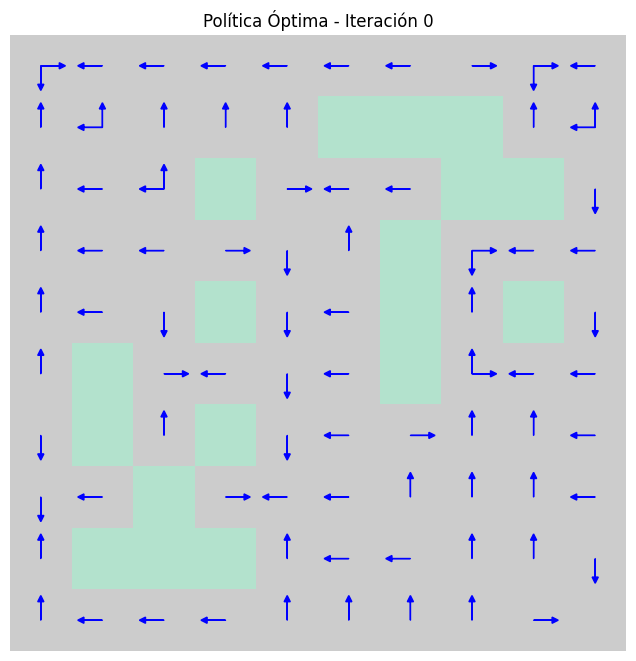

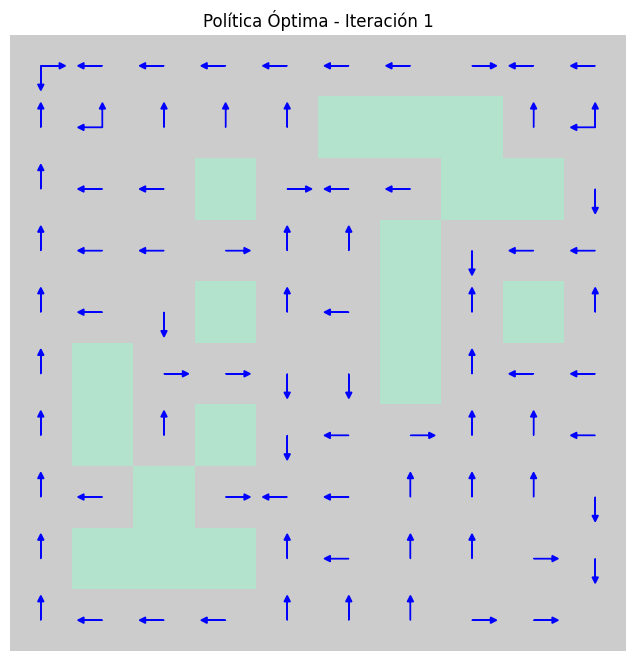

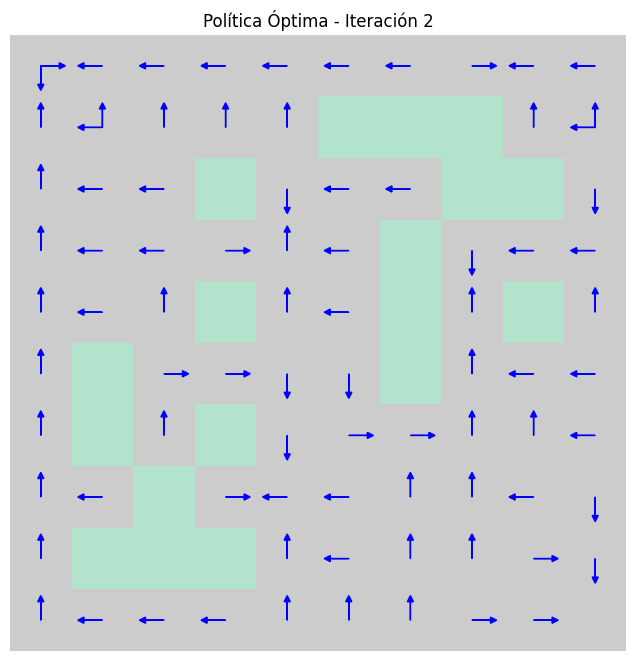

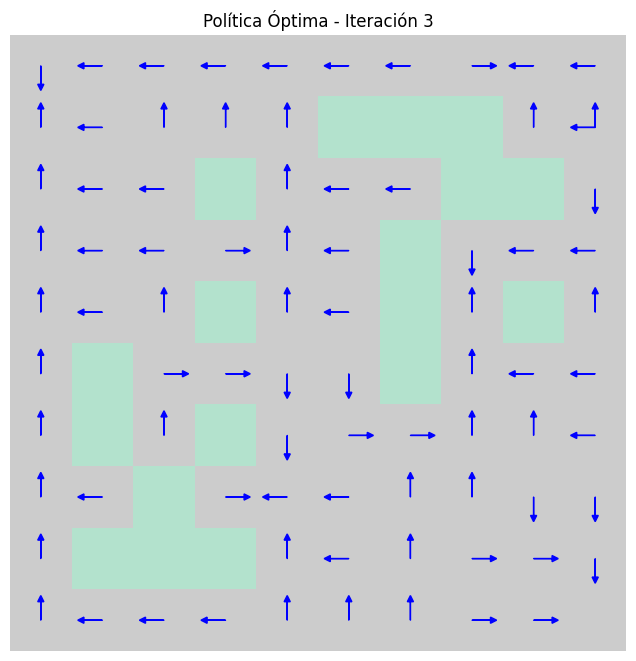

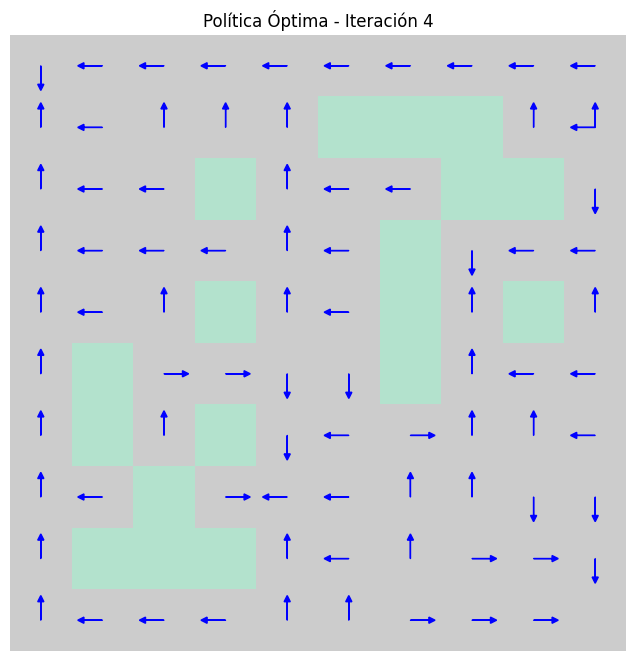

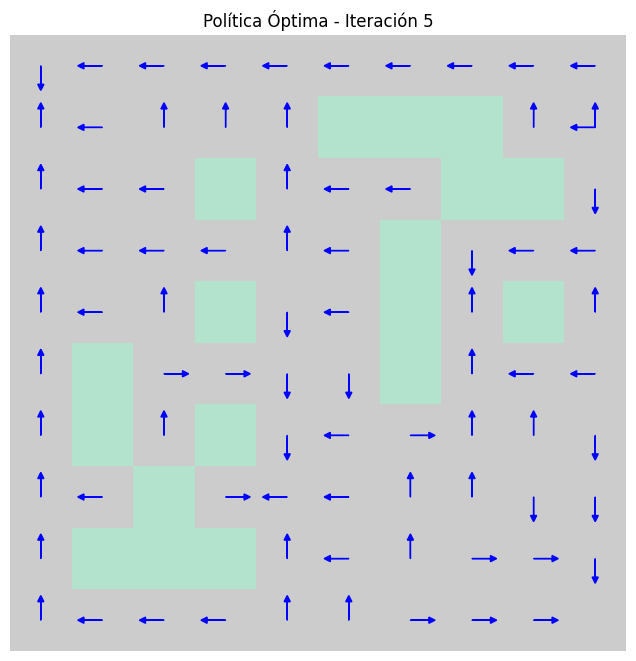

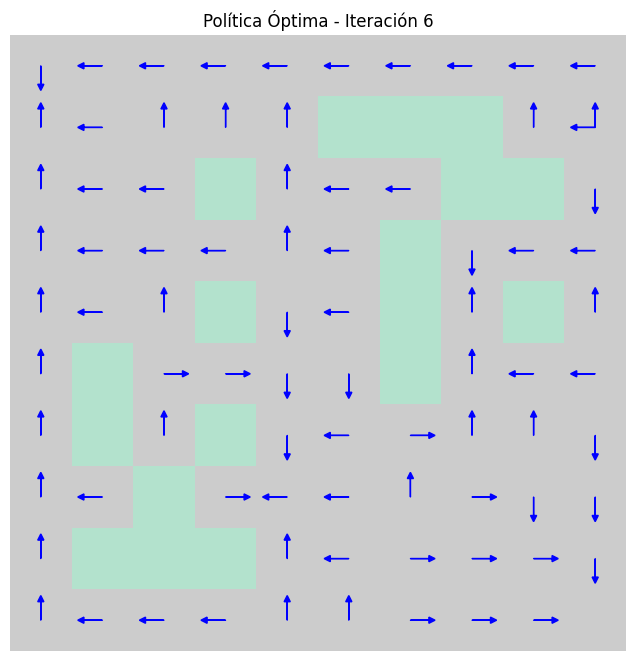

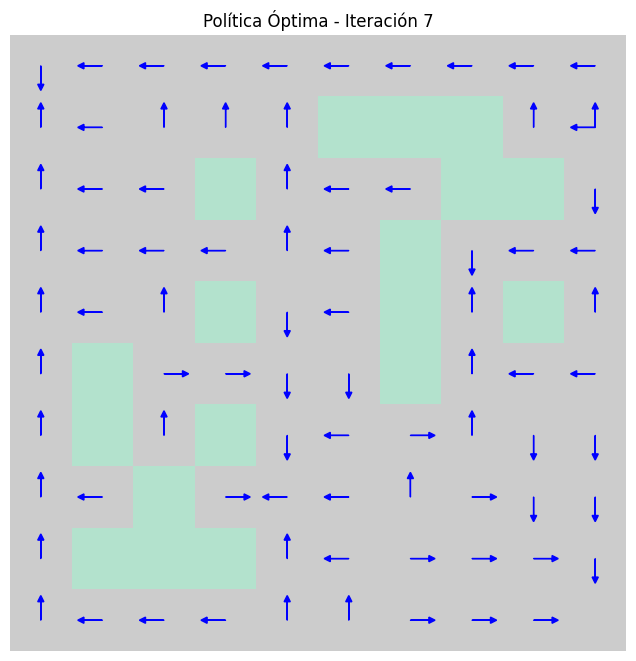

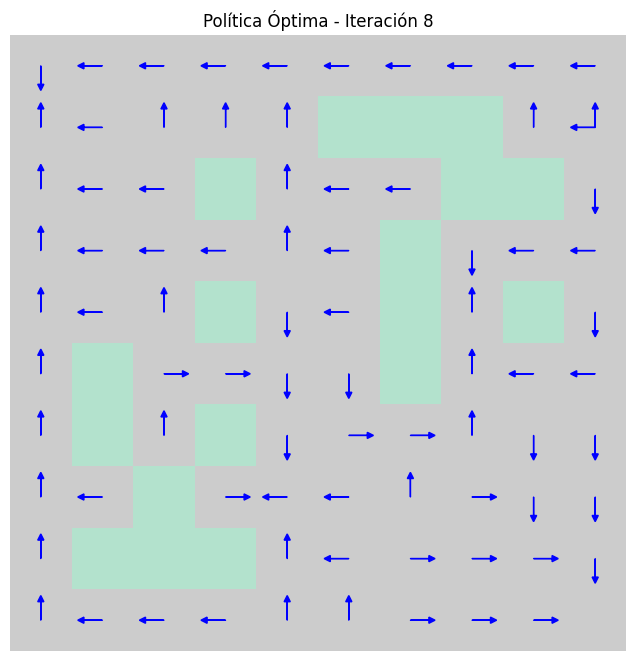

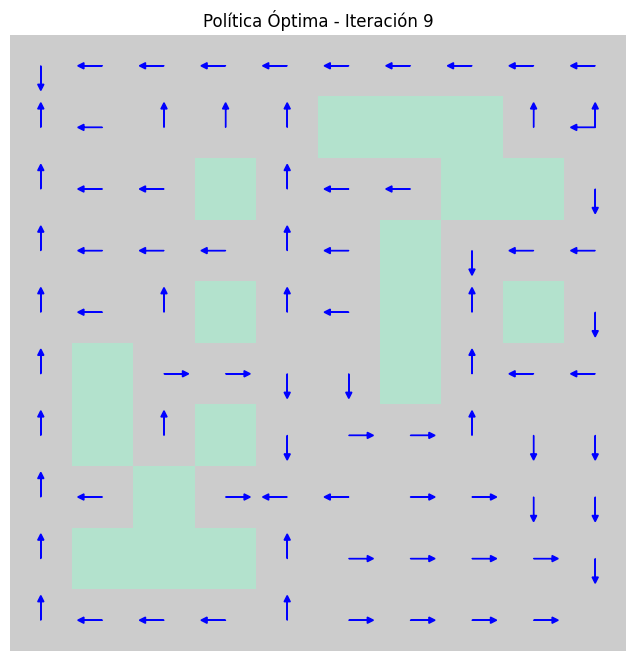

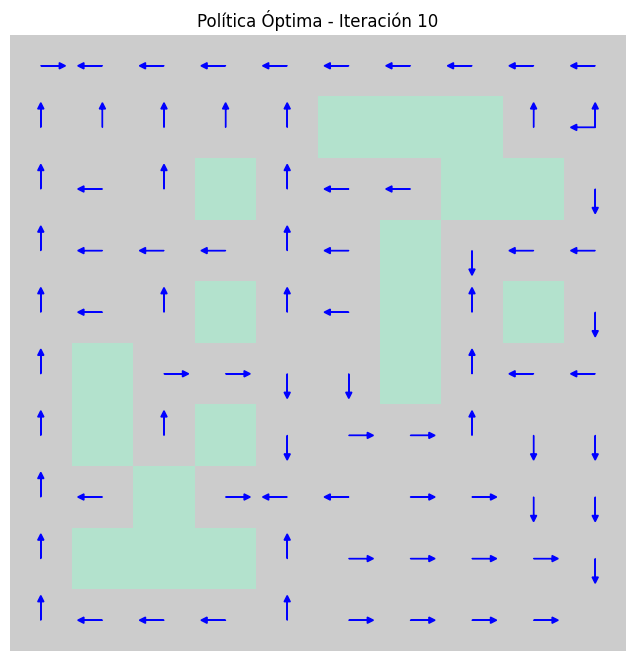

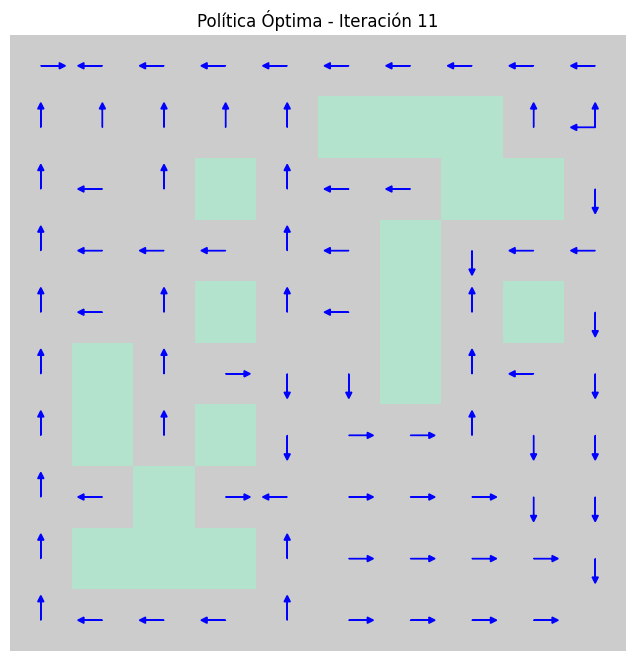

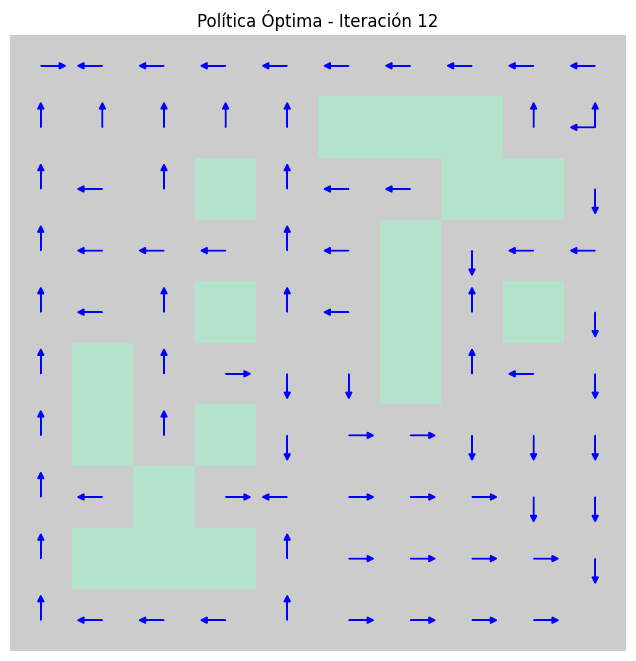

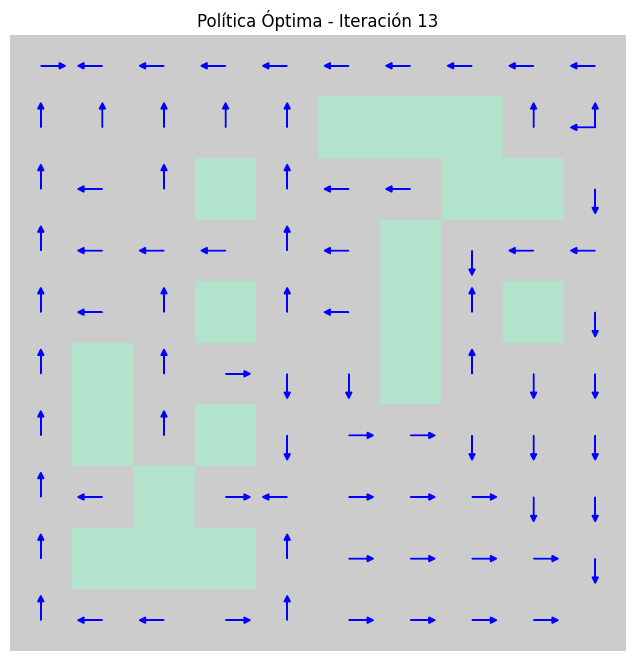

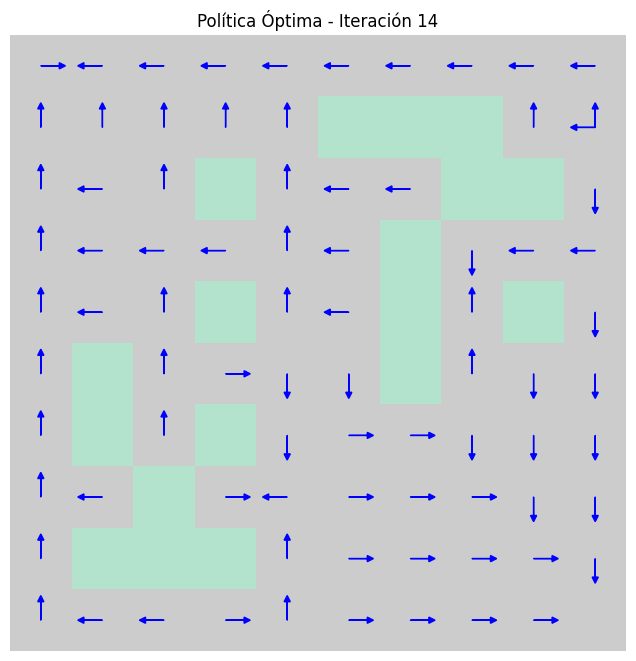

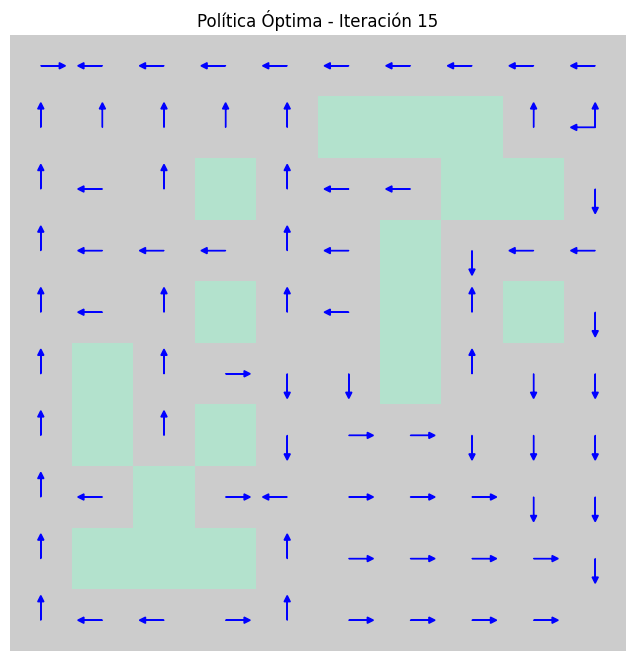

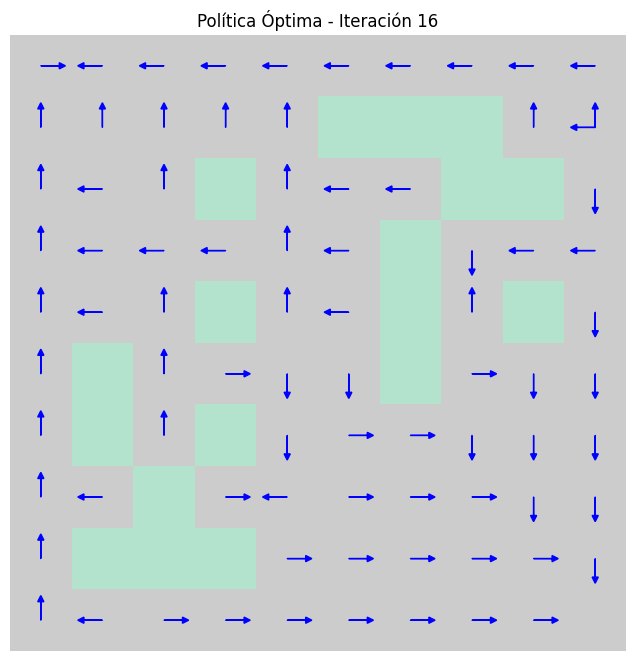

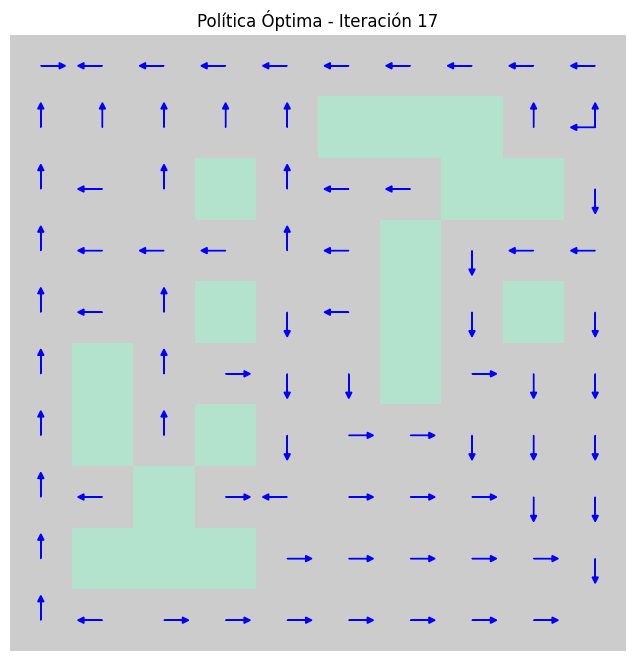

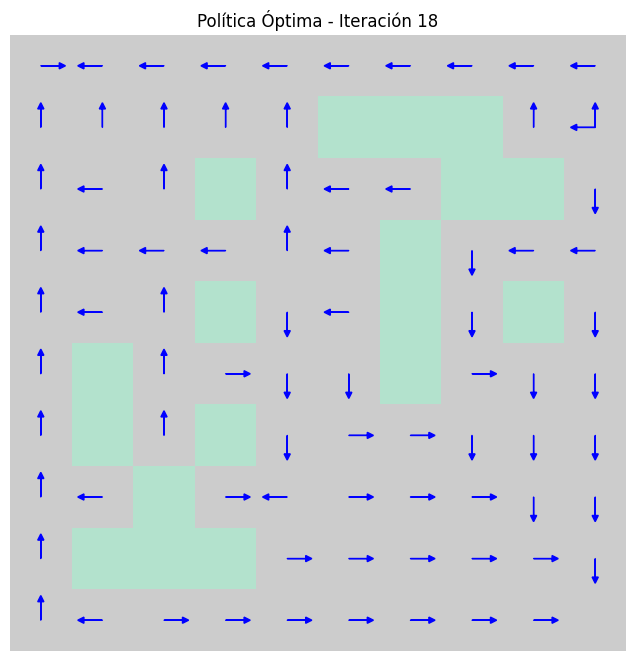

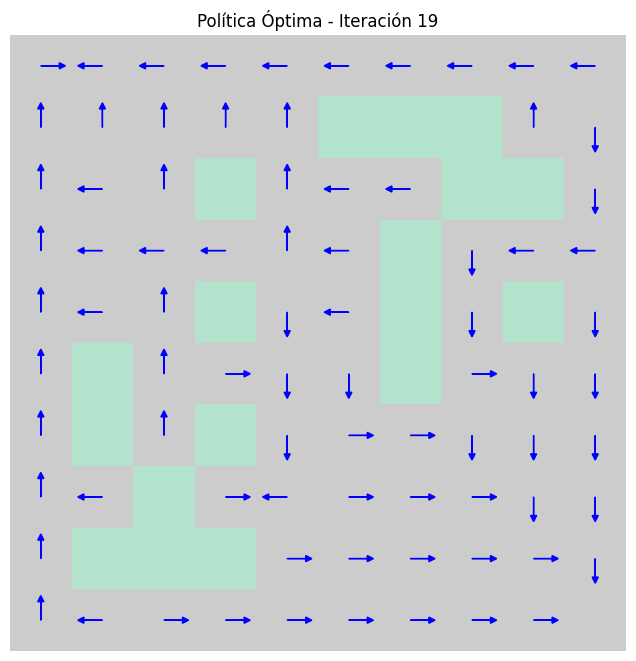

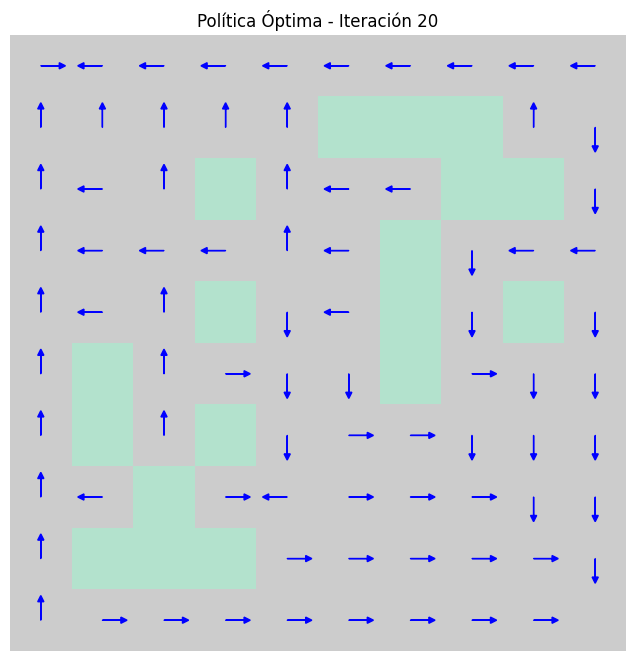

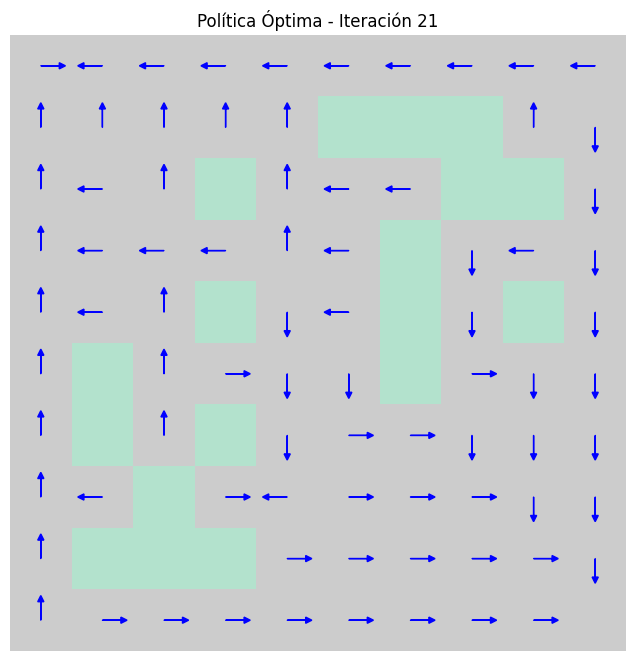

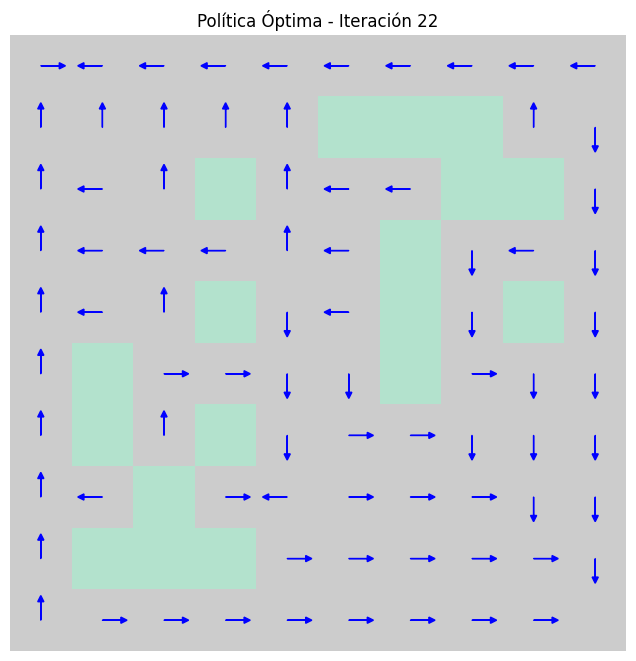

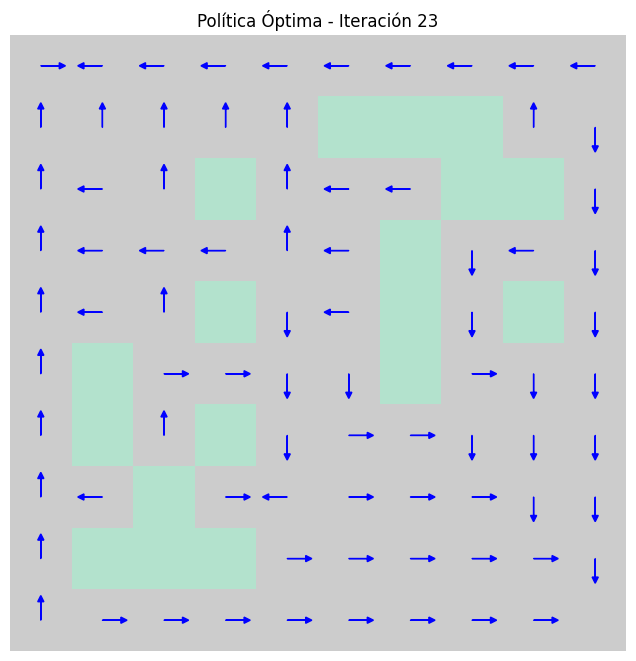

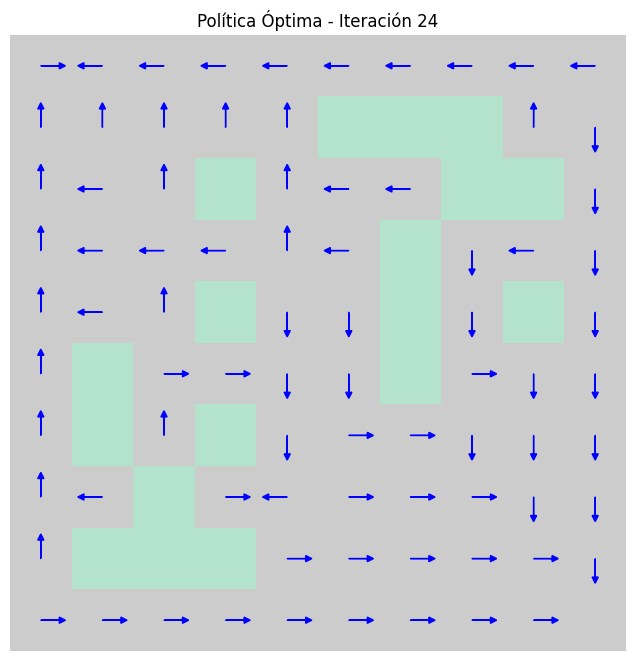

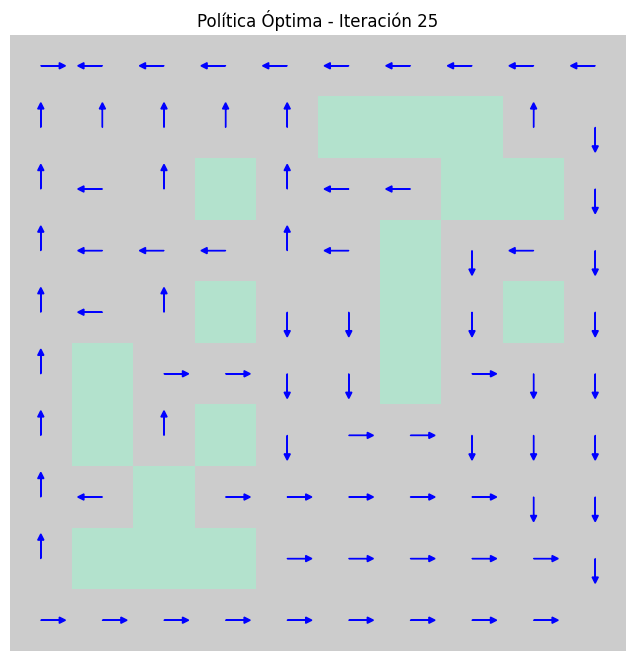

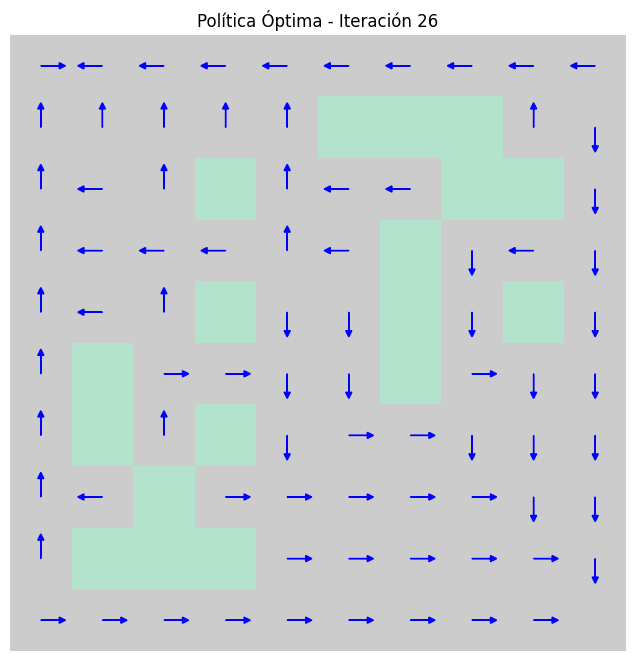

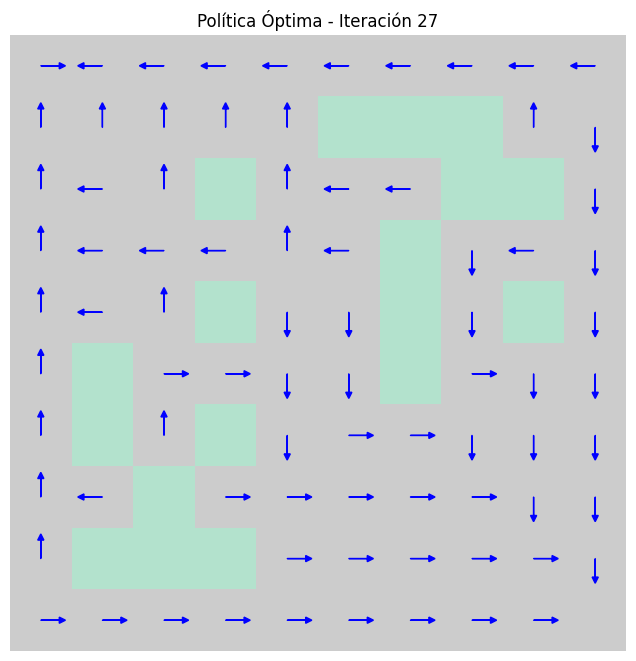

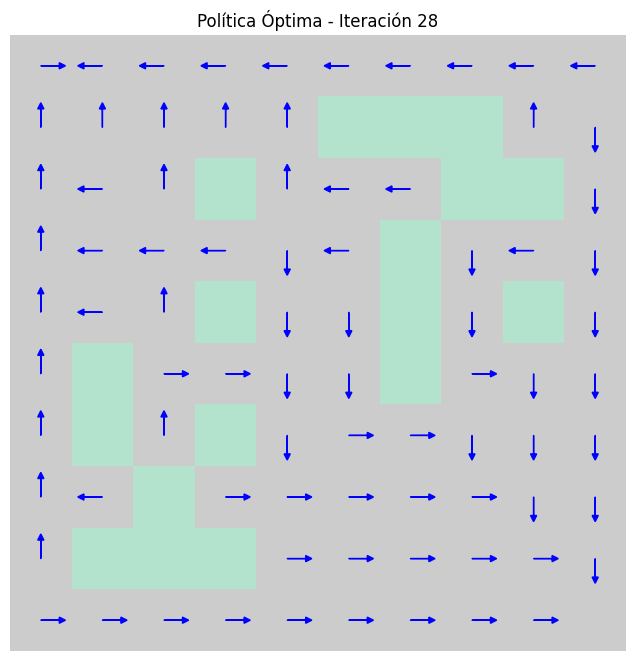

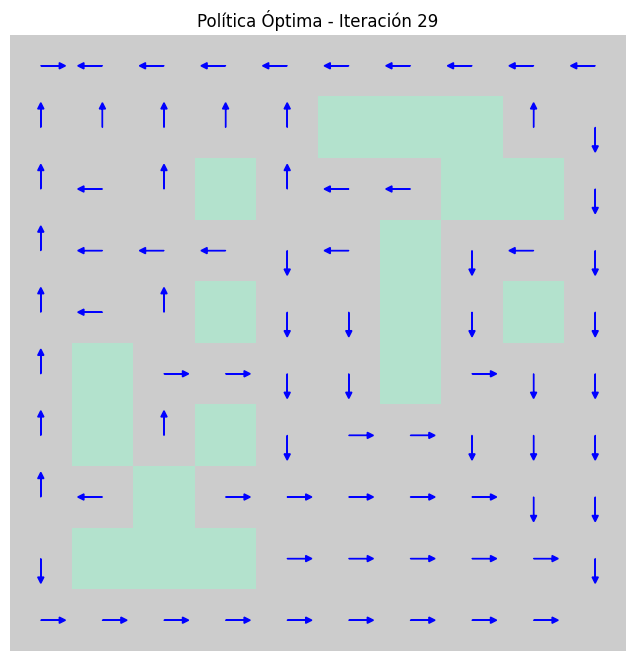

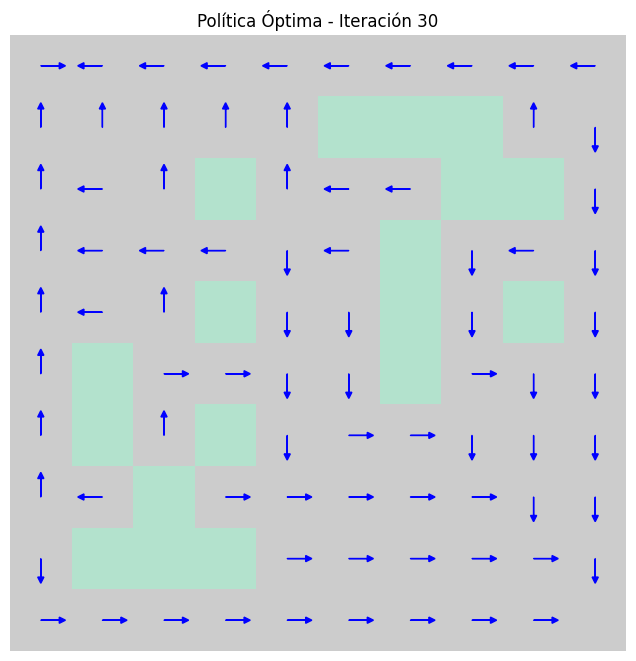

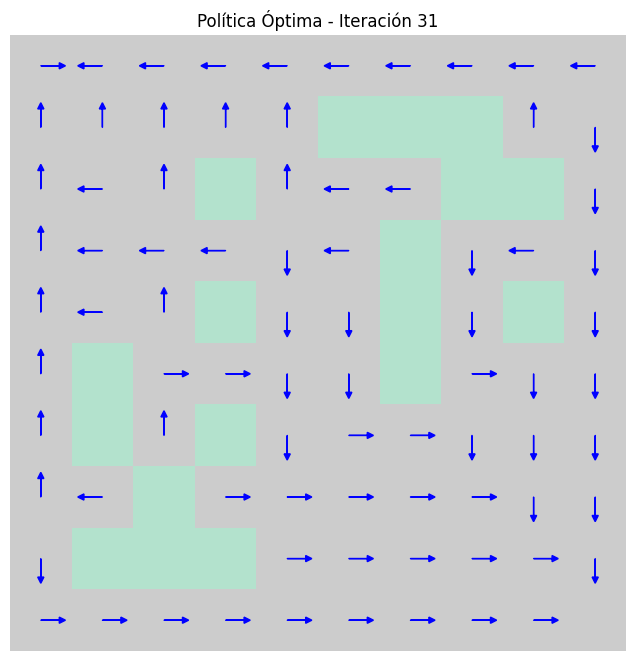

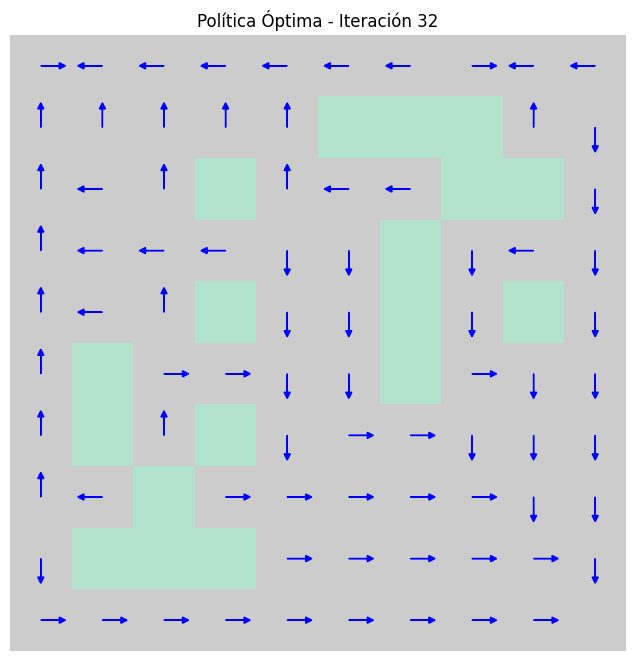

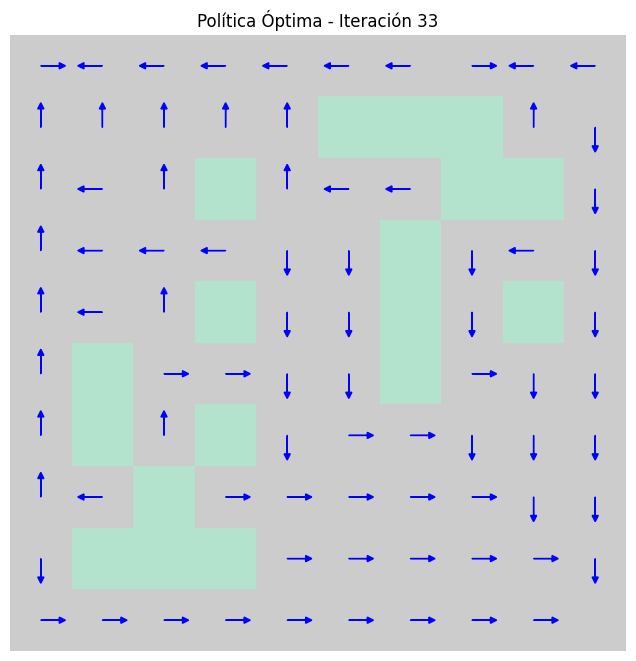

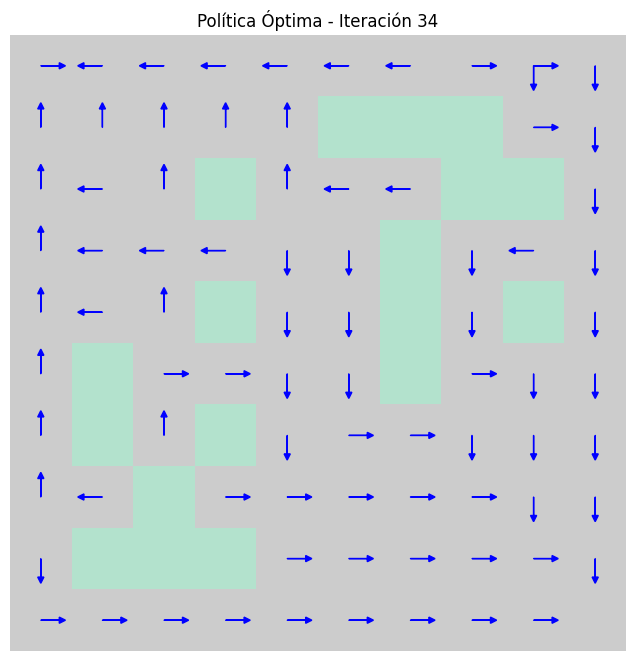

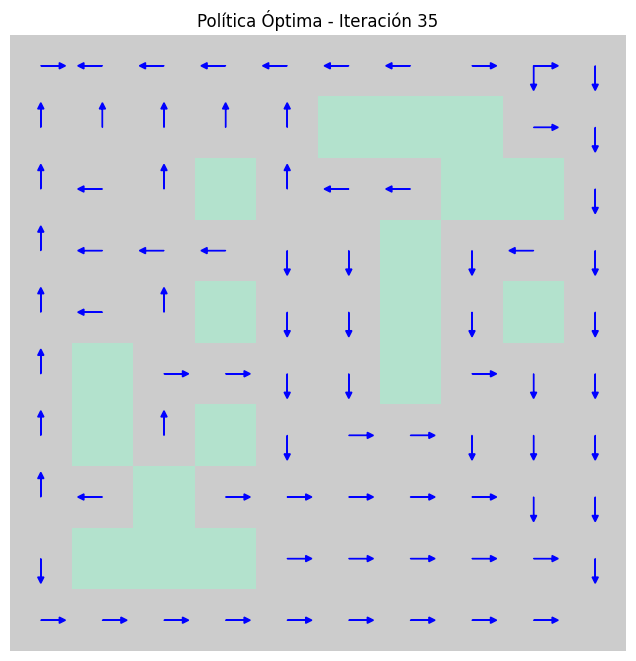

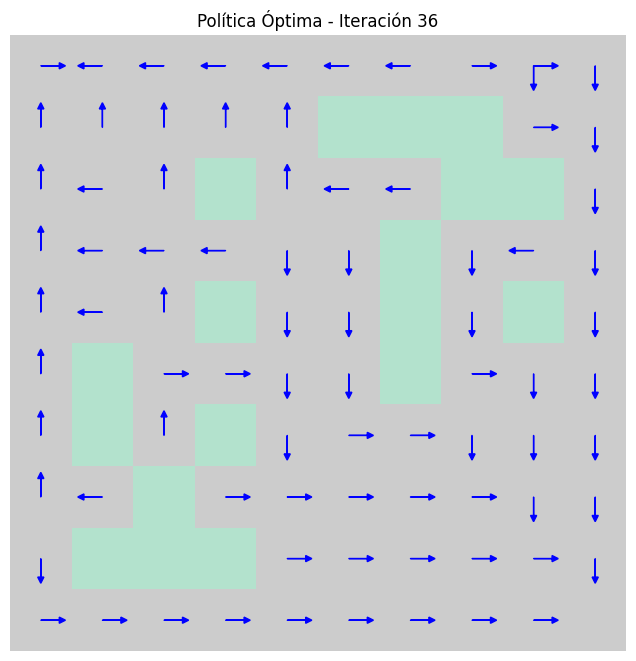

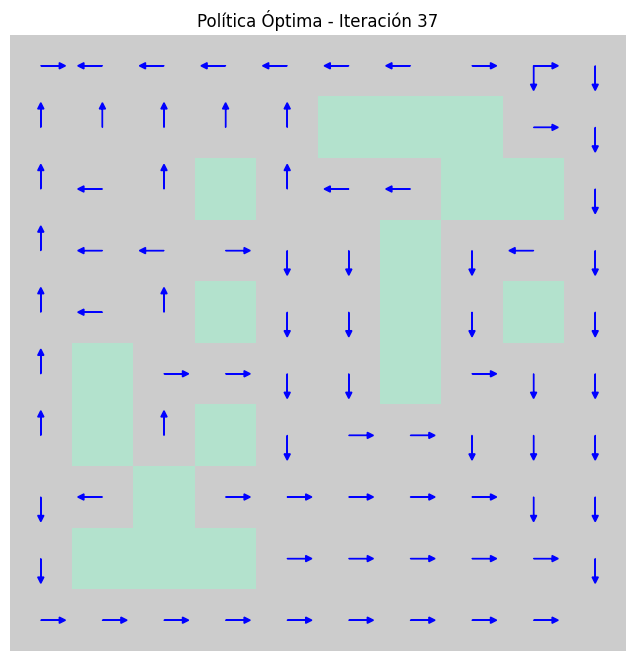

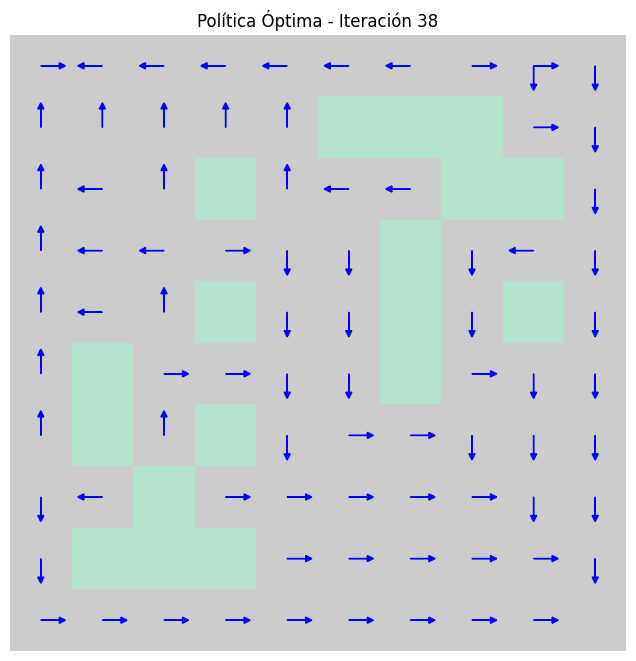

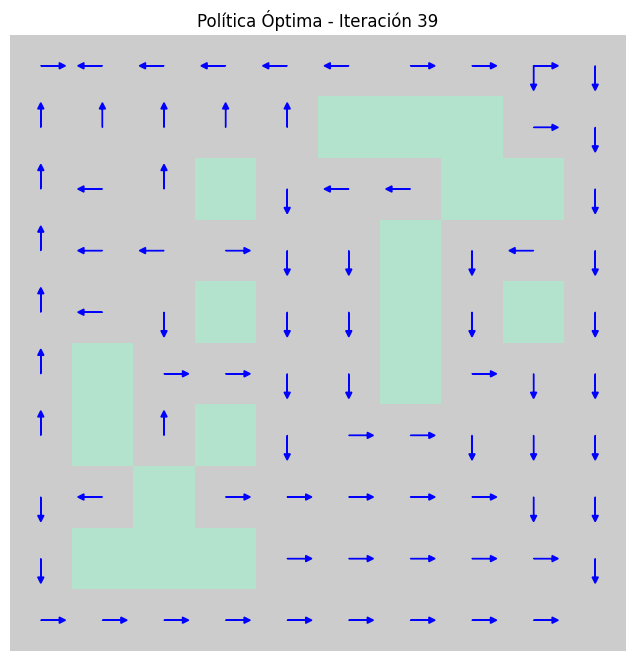

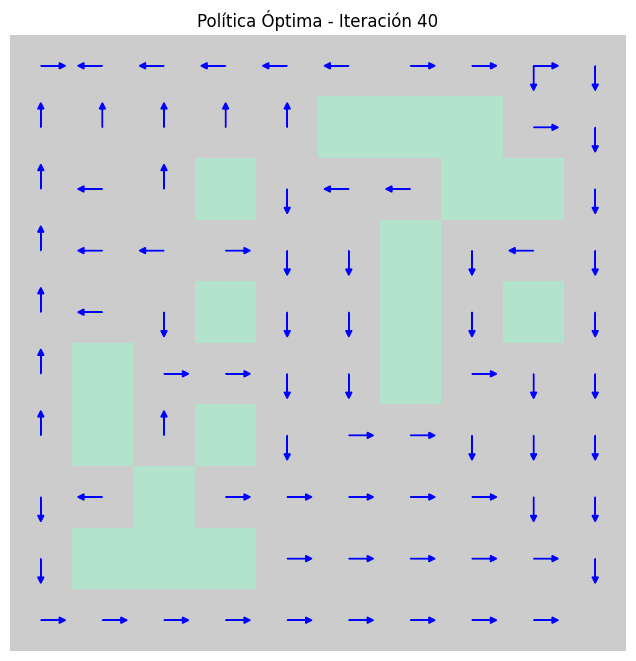

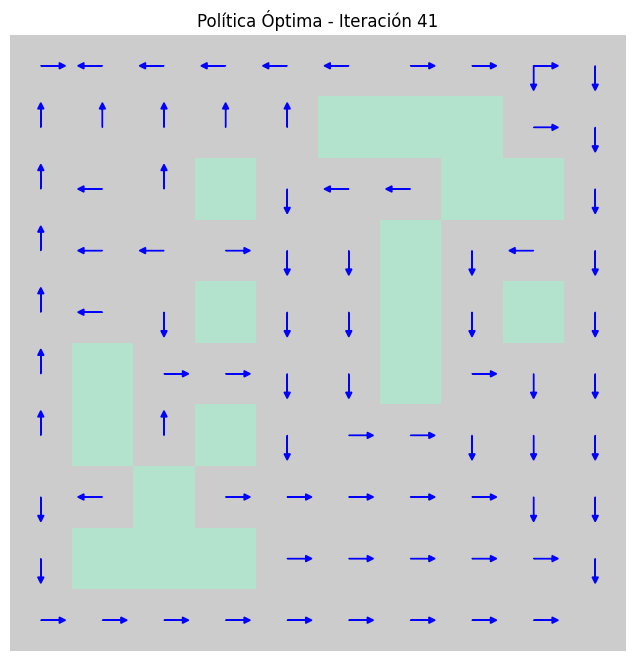

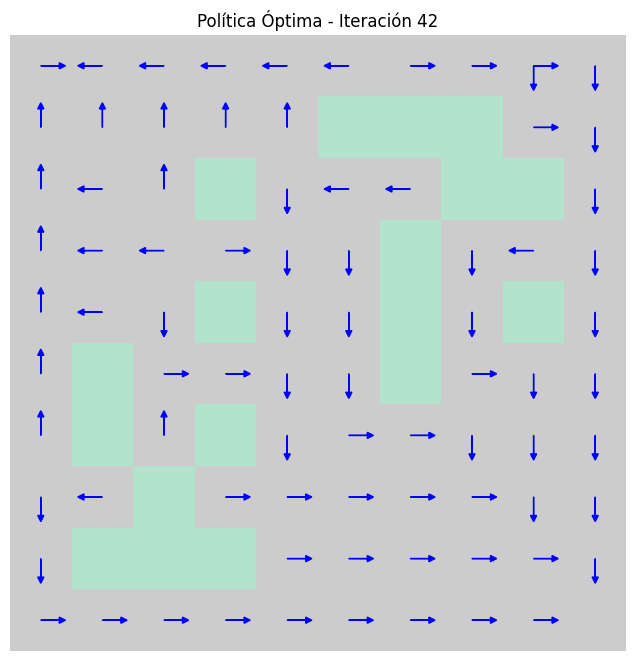

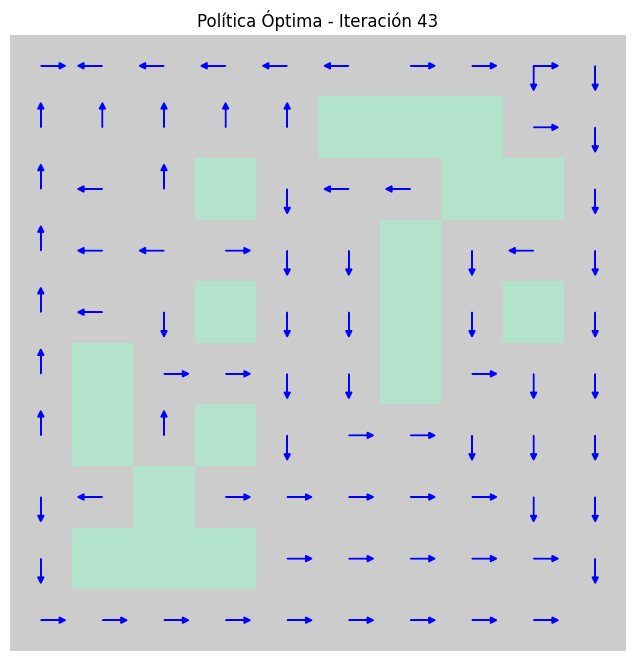

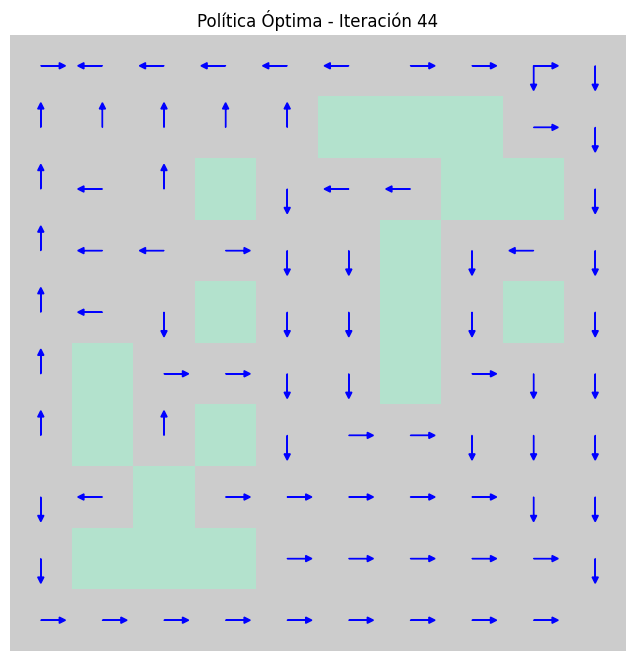

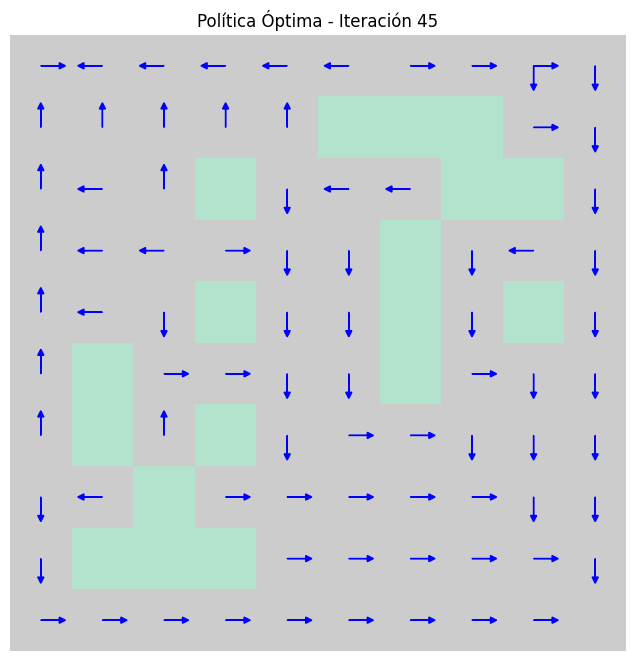

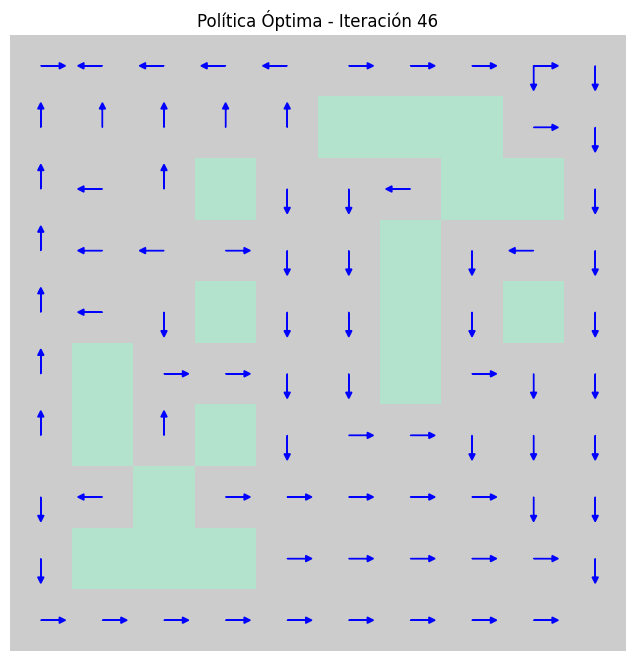

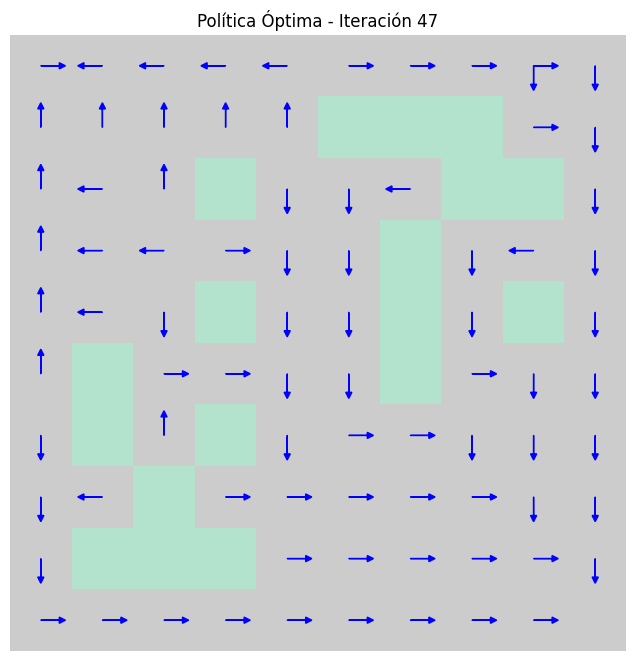

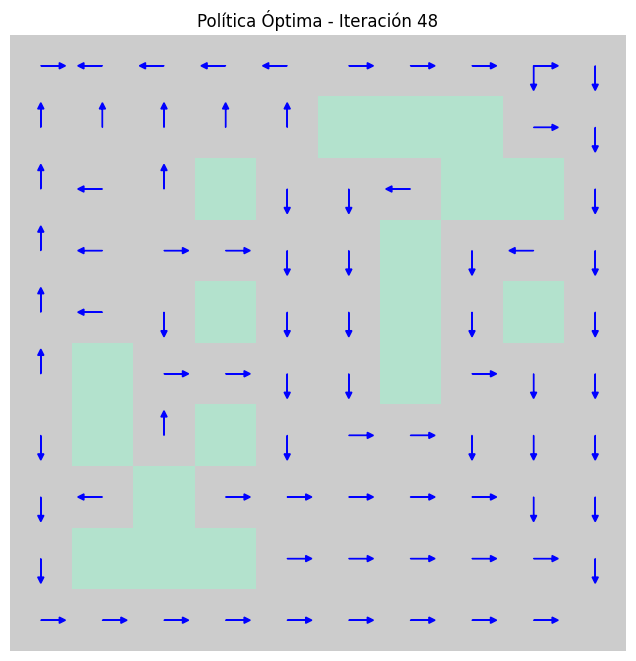

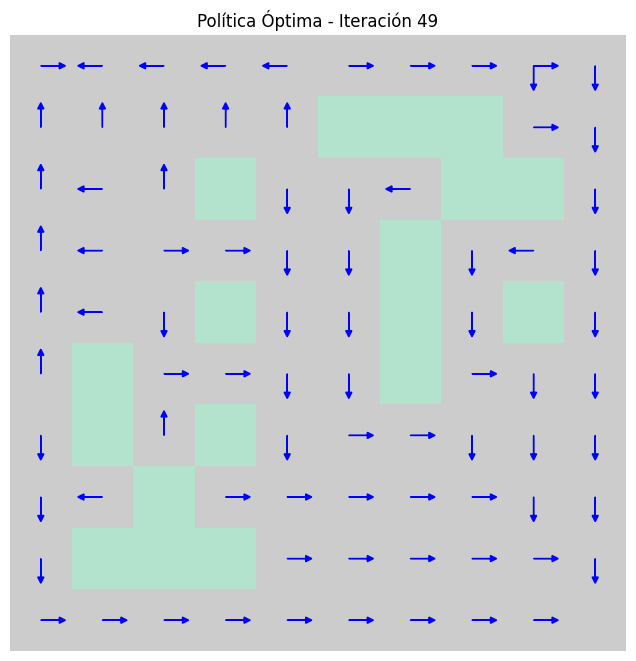

In [123]:
# Ejecutamos el proceso iterativo, mostrando la evolución en cada iteración.
# Instanciamos el laberinto
maze = Maze(n, m, p_obstacle=p_obstacle, seed=42)
# Instanciamos la política uniforme
policy = UniformPolicy(maze)
# Instanciamos el visualizador
visualizer = Visualizer(maze)
policy_visualizer = PolicyVisualizer(maze, gamma=gamma, reward_step=-1)
# Instanciamos la evaluación de la función valor
value_iteration = ValueIteration(maze, policy, gamma=gamma, reward_step=-1)
value_iteration.iterate(max_iter=max_iter, tol=tol, delay=delay, is_sync=False, visualizer=None, policy_visualizer=policy_visualizer)